#Sec.0 Overview 👀


This notebook is created as the hands-on learning material of the [WWW2023 SLU Tutorial](https://github.com/adlnlp/jointNLU_survey). It aims to provide a basic start-up experience of the joint NLU, more specifically, joint intent classification and slot filling, by simply utilizing the pretrained BERT model (👉[See Paper for BERT](http://aclanthology.lst.uni-saarland.de/N19-1423.pdf)). 

Below is an overall structure of this notebook:


*   **Sec.0 Overview (Current section):** Articulates the goals and overall structure of this notebook.
*   **Sec.1 Let's Try BERT:** Covers the foundation of implementing a pretrained BERT model and fine-tuning it for the intent classification task as a pre-exercise (IntentBERT model), with one of the most common NLU benchmark datasets - SNIPs.
*   **Sec.2 BERT for Joint NLU:** Provides the overall procedure of conducting the joint NLU based on the pretrained Bert model by simply modifying the IntentBERT model from Sec.1.
*   **Sec.3 Extension: Applying Joint NLU to In-game Toxicity Detection:** Illustrates an interesting application example of joint NLU in the domain of in-game toxicity, utilizing the same jointBERT model on the dual-level annotated CONDA dataset.





---



# Sec.1 Let's Try BERT! 🤩

BERT (👉[See Paper for BERT](http://aclanthology.lst.uni-saarland.de/N19-1423.pdf)) is a pretrained transformer-based neural network model that can encode the input sequence data into the corresponding contextualized representations which can be utilized for further conducting various targeted tasks. In this section, we will utilize the [`huggingface/transformers`](https://pypi.org/project/transformers/) library from Huggingface🤗 to load the pretrained BERT model and fine-tune it for intent classification task only. This is a start-up exercise to get familiar with the BERT model in terms of input preparation, model definition (especially regarding the utilization of the output representation of BERT model for the targeted task), as well as the training/fine-tuning procudure.

*Some of the content in this section is modified from this [github lab](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Transformers_Joint_Intent_Classification_Slot_Filling_rendered.ipynb). 

## 1.1 The SNIPS Dataset

[SNIPS](https://paperswithcode.com/dataset/snips) is one of the most commonly used Natural Language Understanding benchmark datasets that collects over 16,000 crowdsourced queries distributed among 7 user intents of varying complexity, including: 


*   SearchCreativeWork (e.g. Find me the I, Robot television show),
*   GetWeather (e.g. Is it windy in Boston, MA right now?),
*   BookRestaurant (e.g. I want to book a highly rated restaurant in Paris tomorrow night),
*   PlayMusic (e.g. Play the last track from Beyoncé off Spotify),
*   AddToPlaylist (e.g. Add Diamonds to my roadtrip playlist),
*   RateBook (e.g. Give 6 stars to Of Mice and Men),
*   SearchScreeningEvent (e.g. Check the showtimes for Wonder Woman in Paris). 

The training set contains of 13,084 utterances, the validation set and the test set contain 700 utterances each, with 100 queries per intent. The original datasets comes in [YAML format with inline markdown annotations](https://snips-nlu.readthedocs.io/en/latest/dataset.html). For simplicity, we will directly use the preprocessed variant with B-I-O annotations prepared by [Su Zhu](https://github.com/sz128) that is closer to the representation we will predict. 


Let's first get access to the data files. The following cells will download all the related data needed for this hands-on tutorial, including the dataset and the saved models. 


NOTES: You need to authenticate via your own Google account in order to download the data below. If you have any issue with downloading the data, you can also access our [shared google drive folder](https://drive.google.com/drive/folders/1ZJ45c9cRfi07Zf6Xust6deMqg3tCyal-?usp=share_link), which contains ALL data needed for this exercise. You can just add a shortcut of this shared folder to your own google drive and then access it via mounting your own google drive in colab.







In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate
drive = None
def authenticate():
  global drive
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

# Function for Downloading the files
def downloadFiles(fileIds):
  authenticate()
  
  for fileId in fileIds:    
    
    downloaded = drive.CreateFile({"id": fileId[1]})
    downloaded.GetContentFile(fileId[0])

In [3]:
# Download data files (It may takes some time :D)
downloadFiles([["WWW2023-SLU-data-snips.zip", "1pElToWUIoFH3gRJvNYoOSuGn8KIIhbbB"],["WWW2023-SLU-model-intentbert.zip","1tIldWrP0tgsB0ZB_grDdoKNTXLY3Hx85"],["WWW2023-SLU-model-jointbert-snips.zip","18UU92t1QhHojkC0g7Kd-_LCWE32D8wC1"]])
!unzip "WWW2023-SLU-data-snips.zip" 
!unzip "WWW2023-SLU-model-intentbert.zip" 
!unzip "WWW2023-SLU-model-jointbert-snips.zip"
!rm "WWW2023-SLU-data-snips.zip" 
!rm "WWW2023-SLU-model-intentbert.zip" 
!rm "WWW2023-SLU-model-jointbert-snips.zip"

Archive:  WWW2023-SLU-data-snips.zip
   creating: WWW2023-SLU-data-snips/WWW2023-SLU-data/
   creating: WWW2023-SLU-data-snips/WWW2023-SLU-data/dataset-snips/
  inflating: WWW2023-SLU-data-snips/WWW2023-SLU-data/dataset-snips/test  
  inflating: WWW2023-SLU-data-snips/WWW2023-SLU-data/dataset-snips/train  
  inflating: WWW2023-SLU-data-snips/WWW2023-SLU-data/dataset-snips/valid  
  inflating: WWW2023-SLU-data-snips/WWW2023-SLU-data/dataset-snips/vocab.intent  
  inflating: WWW2023-SLU-data-snips/WWW2023-SLU-data/dataset-snips/vocab.slot  
Archive:  WWW2023-SLU-model-intentbert.zip
   creating: WWW2023-SLU-model-intentbert/WWW2023-SLU-data/
   creating: WWW2023-SLU-model-intentbert/WWW2023-SLU-data/intentbert10/
  inflating: WWW2023-SLU-model-intentbert/WWW2023-SLU-data/intentbert10/checkpoint  
  inflating: WWW2023-SLU-model-intentbert/WWW2023-SLU-data/intentbert10/intentbert10.data-00000-of-00001  
  inflating: WWW2023-SLU-model-intentbert/WWW2023-SLU-data/intentbert10/intentbert10.in

After downloading is completed, you should be able to see three folders in the *Files* structure on the left, which contain the SNIPs dataset and the saved models that we will use later. If you are accessing the data via mounting your own google drive with our shared folder, you can simiply modify the `DATA_DIR` path below to the path to the data folder in your google drive.

In [119]:
# Set the root directory for data resource
ROOT_DIR = "/content" 

In [120]:
DATA_DIR = ROOT_DIR+'/WWW2023-SLU-data-snips/WWW2023-SLU-data/'
MODEL_IB_DIR = ROOT_DIR+'/WWW2023-SLU-model-intentbert/WWW2023-SLU-data/'
MODEL_JB_DIR = ROOT_DIR+'/WWW2023-SLU-model-jointbert-snips/WWW2023-SLU-data/'

Let's take a look at the first several lines from the training set:

In [121]:
from urllib.request import urlretrieve
from pathlib import Path

lines_train = Path(DATA_DIR+"dataset-snips/train").read_text("utf-8").strip().splitlines()
lines_train[:5]

['Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist',
 'put:O United:B-entity_name Abominations:I-entity_name onto:O my:B-playlist_owner rare:B-playlist groove:I-playlist playlist:O <=> AddToPlaylist',
 'add:O the:O tune:B-music_item by:O misato:B-artist watanabe:I-artist to:O the:O Trapeo:B-playlist playlist:O <=> AddToPlaylist',
 'add:O this:O artist:B-music_item to:O my:B-playlist_owner this:B-playlist is:I-playlist miguel:I-playlist bosé:I-playlist playlist:O <=> AddToPlaylist',
 'add:O heresy:B-entity_name and:I-entity_name the:I-entity_name hotel:I-entity_name choir:I-entity_name to:O the:O evening:B-playlist acoustic:I-playlist playlist:O <=> AddToPlaylist']

Some remarks:

- The utterance class label, i.e., the intent, for the voice command appears at the end of each line (after the "<=>" marker).
- Each word-level token is annotated with B-I-O labels using the ":" separator, i.e., the slots.
- B/I/O stand for "Beginning" / "Inside" / "Outside"
- For example, in the first line of the training data above, the "Add:O" means that the word token "Add" is "Outside (O)" of any annotation span (slots). The "Don:B-entity_name" means that "Don" is the "Beginning (B-)" of an annotation of the slot type "entity-name". The "and:I-entity_name" means that "and" is "Inside (I-)" the previously started annotation of slot type "entity-name".




Now, let's write a parsing function for extracting the key information from each data instance, including the intent (label), textual words, slots (labels), and the utterance length:

In [122]:
# Function for parsing each line of data to extract the information for later use
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label, # intent (label)
        "words": " ".join(words), # textual words
        "word_labels": " ".join(word_labels), # slots (labels)
        "length": len(words), # utterance length
    }

Test the parsing function on one of the lines in the data:

In [123]:
parse_line(lines_train[1])

{'intent_label': 'AddToPlaylist',
 'words': 'put United Abominations onto my rare groove playlist',
 'word_labels': 'O B-entity_name I-entity_name O B-playlist_owner B-playlist I-playlist O',
 'length': 8}

This utterance is a voice command of intent type "AddToPlaylist" with three slot annotations:

- an entity-name: "United Abominations",
- a playlist owner: "my",
- a playlist: "rare groove".


The end goal of the NLU is to analyse such voice commands and predict:

- the intent of the speaker: the sentence level class label ("AddToPlaylist"), i.e., the intent classification task;
- extract the interesting "slots" from the sentence by performing word level classification using the B-I-O tags as target classes, i.e., the slot filling task. 






Regarding these two classification-based subtasks, the list of possible classes for the sentence level and the word level classification problems are given as:

In [124]:
# The list of possible classes for intent classification, 7 intents in total
print(Path(DATA_DIR+"dataset-snips/vocab.intent").read_text("utf-8"))

AddToPlaylist
BookRestaurant
GetWeather
PlayMusic
RateBook
SearchCreativeWork
SearchScreeningEvent



In [125]:
# The list of possible classes for slot filling, 72 slots in total
# PS: The "POI" from the "I-poi" slot below stands for "Point of Interest".
print(Path(DATA_DIR+"dataset-snips/vocab.slot").read_text("utf-8"))

B-album
B-artist
B-best_rating
B-city
B-condition_description
B-condition_temperature
B-country
B-cuisine
B-current_location
B-entity_name
B-facility
B-genre
B-geographic_poi
B-location_name
B-movie_name
B-movie_type
B-music_item
B-object_location_type
B-object_name
B-object_part_of_series_type
B-object_select
B-object_type
B-party_size_description
B-party_size_number
B-playlist
B-playlist_owner
B-poi
B-rating_unit
B-rating_value
B-restaurant_name
B-restaurant_type
B-served_dish
B-service
B-sort
B-spatial_relation
B-state
B-timeRange
B-track
B-year
I-album
I-artist
I-city
I-country
I-cuisine
I-current_location
I-entity_name
I-facility
I-genre
I-geographic_poi
I-location_name
I-movie_name
I-movie_type
I-music_item
I-object_location_type
I-object_name
I-object_part_of_series_type
I-object_select
I-object_type
I-party_size_description
I-playlist
I-playlist_owner
I-poi
I-restaurant_name
I-restaurant_type
I-served_dish
I-service
I-sort
I-spatial_relation
I-state
I-timeRange
I-track
O



Now, let's parse all the lines in training set and store the results in pandas DataFrames:

In [126]:
import pandas as pd

parsed = [parse_line(line) for line in lines_train]

# Parse training set
df_train = pd.DataFrame([p for p in parsed if p is not None])
df_train

,intent_label,words,word_labels,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11
...,...,...,...,...
13079,SearchScreeningEvent,find a Consolidated Theatres showing The Good ...,O O B-location_name I-location_name O B-movie_...,10
13080,SearchScreeningEvent,where can i see animated movies in the neighbo...,O O O O B-movie_type I-movie_type B-spatial_re...,9
13081,SearchScreeningEvent,Showtimes for animated movies in the area .,O O B-movie_type I-movie_type B-spatial_relati...,8
13082,SearchScreeningEvent,Which animated movies are playing at Megaplex ...,O B-movie_type I-movie_type O O O B-location_n...,11


In [127]:
# Intent label distribution, it can be seen that the training set is almost evenly distributed regarding the intents 
df_train.groupby("intent_label").count()

,words,word_labels,length
intent_label,,,
AddToPlaylist,1842,1842,1842
BookRestaurant,1873,1873,1873
GetWeather,1900,1900,1900
PlayMusic,1900,1900,1900
RateBook,1856,1856,1856
SearchCreativeWork,1854,1854,1854
SearchScreeningEvent,1859,1859,1859


array([[<Axes: title={'center': 'length'}>]], dtype=object)

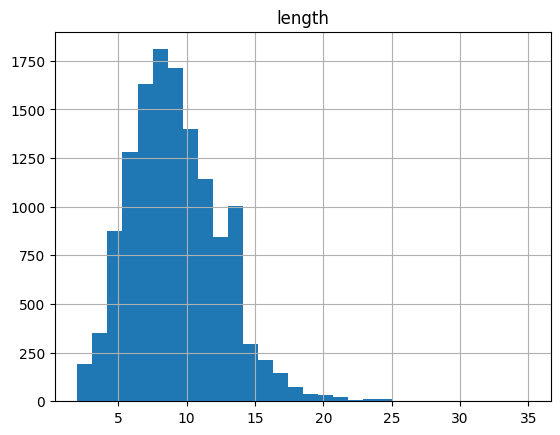

In [128]:
# Query length distribution
df_train.hist("length", bins=30)

Then let's do the same to the validation and test set for later use.

In [129]:
# Similarly, read and parse the validation and test set and and store the results in pandas DataFrames
lines_valid = Path(DATA_DIR+"dataset-snips/valid").read_text("utf-8").strip().splitlines()
lines_test = Path(DATA_DIR+"dataset-snips/test").read_text("utf-8").strip().splitlines()

df_valid = pd.DataFrame([parse_line(line) for line in lines_valid])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])

## 1.2 Pre-exercise: BERT for Intent Classiication 

To get familiar with how to utilize the pretrained BERT model for fine-tuning the targeted tasks, in terms of input preparation, model definition with task adaptation (i.e., utilization of the BERT output representation for final task), as well as the procedure of training/fine-tuning, let's ignore the slot filling task for now and only focus on the sentence-level intent classification. We will use the [`huggingface/transformers`](https://pypi.org/project/transformers/2.11.0/) package that provides both TF2/Keras and Pytorch APIs.

In [15]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00


### The BERT Tokenizer

First, let's load a pre-trained tokenizer and test it on a sample sentence from the training set:

In [132]:
from transformers import BertTokenizer

# We're using the Bert tokenizer for the 'bert-base-cased' pretrained model, which is based on WordPiece.
# More details of the 'bert-base-case' model description can be found from https://huggingface.co/bert-base-cased
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name) # It download the vocabulary from huggingface.co and cache

Get a sample sentence from the training set and try with the Bert tokenizer we just constructed.

In [133]:
# Get a sample sentence
first_sentence = df_train.iloc[0]["words"]
first_sentence

'Add Don and Sherri to my Meditate to Sounds of Nature playlist'

The `tokenizer.tokenize()` function can split(tokenize) the sentence into tokens based on the Bert tokenizer vocabulary. As can be seen that BERT uses subword tokens so the length of the tokenized sentence is likely to be larger than the number of words in the sentence.

In [134]:
# tokenizer.tokenize() tokenizes the input sencence into sub-words based tokens
tokenizer.tokenize(first_sentence)

['Ad',
 '##d',
 'Don',
 'and',
 'She',
 '##rri',
 'to',
 'my',
 'Me',
 '##dit',
 '##ate',
 'to',
 'Sounds',
 'of',
 'Nature',
 'play',
 '##list']


The `tokenizer.encode()` function can convert the utterance directly into the corresponding token ids. Each token id is a unique integer id of the corresponding tokens in the vocabulary that makes it fast to lookup the right column in the input layer token embedding:

In [135]:
# tokenizer.encode() encodes the input sentence into the BERT-vocab-based integers, which aligns with the tokenized sub-words
# Comparing with the tokenized sequence above, two more tokens are included, which are the two special tokens '[CLS]' and '[SEP]' 
# from the BERT input format (See following cells for more detail)
tokenizer.encode(first_sentence)

[101,
 24930,
 1181,
 1790,
 1105,
 1153,
 14791,
 1106,
 1139,
 2508,
 17903,
 2193,
 1106,
 10560,
 1104,
 7009,
 1505,
 7276,
 102]

The mapping can be inspected in the `tokenizer.vocab` attribute:

In [136]:
bert_vocab_items = list(tokenizer.vocab.items())
print(bert_vocab_items[101])
print(bert_vocab_items[24930])
print(bert_vocab_items[1181])
print("...")
print(bert_vocab_items[102])


('[CLS]', 101)
('Ad', 24930)
('##d', 1181)
...
('[SEP]', 102)


In [137]:
tokenizer.vocab_size

28996

We can also easily decode the encoded integer back to the original text using the `tokenizer.decode()` function.

In [138]:
# tokenizer.decode() converts the BERT-vocab-based integers back to the original text. 
# It can be seen that the sub-word will be automatically assembled as the single word from the original text.
tokenizer.decode(tokenizer.encode(first_sentence))

'[CLS] Add Don and Sherri to my Meditate to Sounds of Nature playlist [SEP]'

Remarks:

- The `[CLS]` and `[SEP]` are the two special tokens applied by BERT
- The first token `[CLS]` is prepended at the beginning of the sequence and is used by the pre-training task for sequence classification, i.e., it aims to represent the global semantic representation of the whole sequence. In the implementation of Bert, it uses the representation of `[CLS]` token passed through a pooler layer, which contains a dense layer with a tanh activation, for sequence-level classification. It is called as *pooled output*.
- Here we want to use BERT to compute a global representation of a single voice command at a time. Thus, we could reuse the *pooled output* representation of the `[CLS]` token for sequence classification. Alternatively we can also pool the representations of all the tokens of the voice command (e.g. global average) and use that as the input of the final sequence classification layer.
- The last token `[SEP]` is a separator for the pre-training task that classifies if a pair of input sentences are consecutive in a corpus or not (next sentence prediction).


To perform transfer learning (i.e., conduct fine-tuning), we will need to work with padded sequences so they all have the same sizes. The histogram below shows that after tokenization, 43 tokens are enough to represent all the voice commands in the training set. Thus, we can just set the max length to 45 later for encoding the batch inputs.

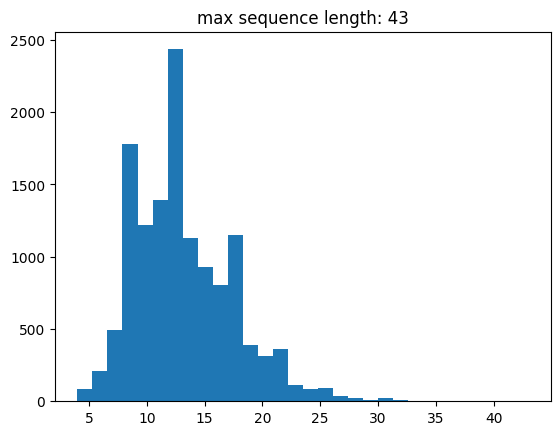

In [139]:
import matplotlib.pyplot as plt

# Check the sequence length distribution after encoding into the BERT-formatted tokenized sequence
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

### Encoding the Dataset with the Tokenizer

Let's now encode the full train / validation and test sets with our tokenizer to get padded numpy arrays of integers:

In [140]:
import numpy as np

def encode_dataset(tokenizer, text_sequences, max_length):
    # initialize the zero-valued array with the shape of (data size, max sequence length)
    # so that we can just fill in the encoded tokens into it, letting those 0 values that are not replaced with encoded tokens be the padding tokens
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence) # encode the sequence into Bert-formatted integers
        token_ids[i, 0:len(encoded)] = encoded # fill in the encoded integers into the initialized zero-valued array
    attention_masks = (token_ids != 0).astype(np.int32) # create the attention mask, see the details in the follow-up cell
    return {"input_ids": token_ids, "attention_mask": attention_masks}

# Encode the training set
# Here we use 45 as our max sequence length
encoded_train = encode_dataset(tokenizer, df_train["words"], 45)

# The 'input_ids' is the indices of input sequence tokens in the vocabulary.
# The converted result is a padded numpy arrays of integers which has shape (data_size, max_length), i.e., (13084, 45) in this case.
# As you can see all the 0s in the end represent the padding tokens
encoded_train["input_ids"]

array([[  101, 24930,  1181, ...,     0,     0,     0],
       [  101,  1508,  1244, ...,     0,     0,     0],
       [  101,  5194,  1103, ...,     0,     0,     0],
       ...,
       [  101, 27640,  1116, ...,     0,     0,     0],
       [  101,  5979,  6608, ...,     0,     0,     0],
       [  101,  1327,  2523, ...,     0,     0,     0]], dtype=int32)

In [141]:
# The 'attention mask' is to avoid performing attention on padding token indices
# In the attention_mask, 1 indicates the real word in the tokenized sentences (NOT masked) while 0 means paddings (masked)
encoded_train["attention_mask"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [142]:
# Similarly, let's encode validation and test set
encoded_valid = encode_dataset(tokenizer, df_valid["words"], 45)
encoded_test = encode_dataset(tokenizer, df_test["words"], 45)

### Encoding the Intent Classification Targets

Now, let's prepare the target labels for the intent detection. To do so we build a simple mapping from the auxiliary files that store the intents:

In [143]:
intent_names = Path(DATA_DIR+"dataset-snips/vocab.intent").read_text("utf-8").split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
# It can map the 7 intents to the corresponding unique integer/index
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

Then we can convert the actual intent labels of each data instance into the corresponding integer/index using the mapping.

In [144]:
# Get the mapped intent integer labels for the training set
intent_train = df_train["intent_label"].map(intent_map).values
intent_train

array([0, 0, 0, ..., 6, 6, 6])

In [145]:
# Similarly, get the mapped intent integer labels for the validation and test sets
intent_valid = df_valid["intent_label"].map(intent_map).values
intent_test = df_test["intent_label"].map(intent_map).values

### Pretrained BERT model and its Output?

So far, we've done the bert-formatted input praperation (including the input sequence data encoding and the intent labels conversion). Now, let's move to the modeling part. 

First, let's try loading a pretrained BERT model using the [huggingface transformers](https://pypi.org/project/transformers/2.11.0/) package:

In [146]:
from transformers import TFAutoModel

# We're using the 'bert-base-cased' pretrained model
# It instantiates the Bert model and loads the pretrained weights for the 'bert-base-cased' model
base_bert_model = TFAutoModel.from_pretrained("bert-base-cased")
base_bert_model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


Let's try to feed some data into the pretrained BERT model and see what the output representation looks like.

In [147]:
# Let's just use the encoded validation data
encoded_valid

{'input_ids': array([[  101,   142, 13894, ...,     0,     0,     0],
        [  101,  2825,   179, ...,     0,     0,     0],
        [  101, 24930,  1181, ...,     0,     0,     0],
        ...,
        [  101,  1525,   170, ...,     0,     0,     0],
        [  101,  4630,  1143, ...,     0,     0,     0],
        [  101,  1327,  1159, ...,     0,     0,     0]], dtype=int32),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)}

In [148]:
# Feed them into the BERT model and get the model output
outputs = base_bert_model(encoded_valid)

# As you can see, the returned output has two elements
len(outputs)

2

The **first output** of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence** (Yes, we will use it for the slot filling later!):

In [149]:
# As is shown in the log below, the first output shape is (700, 45, 768), 700 refers to the data size of the validation set, 
# 45 is the sequence length, 768 is the predefined hidden (feature) size of the pretrained Bert_base model
outputs[0].shape

TensorShape([700, 45, 768])

The **second output** of the BERT model is a tensor with shape `(batch_size, output_dim)` which is the vector representation of the special token `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**. This will be used as the features of our Intent classifier for now:

In [150]:
# Again, 700 refers to the data size of the validation set, 768 is the predefined hidden (feature) size of the pretrained Bert_base model
outputs[1].shape

TensorShape([700, 768])

### The IntentBert!


Now, let's define the BERT model for intent classification! We will use the `self.bert` pre-trained model in the `call` method and only consider the pooled features (the second output of the Bert model) while ignoring the token-wise sequence features (the first output of the Bert model) for now.

In [155]:
import tensorflow as tf
import warnings
warnings. filterwarnings('ignore')
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy



class IntentBert(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="bert-base-cased",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function instead of the model itself.
        self.intent_classifier = Dense(intent_num_labels)

    def call(self, inputs, training=False):
        outputs = self.bert(inputs, training=training)
        pooled_output = outputs[1]
        # only consider the pooled_output for intent classification
        # Recap: the pooled_output is the (second) output of the Bert model, which is the representation of the [CLS] token passed through a pooler layer, which contains the dense layer with a tanh activation 
        # The pooled_output can serve as the global representation of the sequence
        pooled_output = self.dropout(pooled_output, training=training)
        intent_logits = self.intent_classifier(pooled_output)
        return intent_logits

# Initialize the IntentBert model
intent_model = IntentBert(intent_num_labels=len(intent_map))

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


As we can see our classification model outputs logits (i.e. that is unnormalized real numbers output from a log function) instead of probabilities. Here we configure the loss function by setting the `from_logits=True` (`SparseCategoricalCrossentropy(from_logits=True)`) accordingly. By doing this, the loss function accepts the unnormalized logits directly and will apply the softmax normalization layer accordingly when calculating the loss.



In [156]:
# Configure the training settings
intent_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

In [157]:
# Train IntentBert model by fine-tuning the pretrained Bert model 
#history = intent_model.fit(encoded_train, intent_train, epochs=10, batch_size=128,validation_data=(encoded_valid, intent_valid))  

# To save the running time, here we will directly load the weights of the model that we've already trained over 10 epochs for demonstration
# If you want to train it yourself, you can uncomment the above code for training using .fit() above - make sure you are using the GPU runtime for faster training
intent_model.load_weights(MODEL_IB_DIR+'intentbert10/intentbert10')


To demonstrate the 'ability' of the trained IntentBert model for intent classification, let's define a `detect_intent()` function that can classify any input text query into one of the focused intents.

In [158]:
def detect_intent(text, tokenizer, model, intent_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # make batch_size = 1
    class_id = model(inputs).numpy().argmax(axis=1)[0]
    return intent_names[class_id]


detect_intent("Book a table for two at La Tour d'Argent for Friday night.",
         tokenizer, intent_model, intent_names)

'BookRestaurant'

In [159]:
detect_intent("I would like to listen to Anima by Thom Yorke.",
         tokenizer, intent_model, intent_names)

'PlayMusic'

In [160]:
detect_intent("Will it snow tomorrow in Saclay?",
         tokenizer, intent_model, intent_names)

'GetWeather'

In [161]:
detect_intent("Where can I see to the last Star Wars near Odéon tonight?",
         tokenizer, intent_model, intent_names)

'SearchScreeningEvent'



---



# Sec.2 Bert for Joint NLU 💬

In Sec.1, we've practised how to utilize the output representation of the pretrained BERT model to do the intent classification task, more specifically, utilizing the second element of the returned model output, which is the pooled representation for the sequence as a whole. Now, let's move on to our final NLU task goal regarding both intent classification and slot filling.

*NOTE: The following code cells require the running of previous sections!*

### Encoding the Slot Filling Targets

In the previous sections, we've already encoded the input sequences and the intent labels. To do the joint NLU, we will also prepare the slot labels in order to perform word level (or token level) classification of the BIO slots.


Let's first load the list of possible word token labels and augment it with an additional padding label to be able to ignore special tokens, i.e., this padding label serves as a general ground truth label for all the special tokens such as the `[CLS]`/`[SEP]` and the `padding` tokens that are out of our interests for prediction so that we can easily ignore them later when evaluating our model prediction performance. 

In [162]:
slot_names = ["[PAD]"]
slot_names += Path(DATA_DIR+"dataset-snips/vocab.slot").read_text("utf-8").strip().splitlines()
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
# We add the special slot label [PAD] with the corresponding index of 0
slot_map

{'[PAD]': 0,
 'B-album': 1,
 'B-artist': 2,
 'B-best_rating': 3,
 'B-city': 4,
 'B-condition_description': 5,
 'B-condition_temperature': 6,
 'B-country': 7,
 'B-cuisine': 8,
 'B-current_location': 9,
 'B-entity_name': 10,
 'B-facility': 11,
 'B-genre': 12,
 'B-geographic_poi': 13,
 'B-location_name': 14,
 'B-movie_name': 15,
 'B-movie_type': 16,
 'B-music_item': 17,
 'B-object_location_type': 18,
 'B-object_name': 19,
 'B-object_part_of_series_type': 20,
 'B-object_select': 21,
 'B-object_type': 22,
 'B-party_size_description': 23,
 'B-party_size_number': 24,
 'B-playlist': 25,
 'B-playlist_owner': 26,
 'B-poi': 27,
 'B-rating_unit': 28,
 'B-rating_value': 29,
 'B-restaurant_name': 30,
 'B-restaurant_type': 31,
 'B-served_dish': 32,
 'B-service': 33,
 'B-sort': 34,
 'B-spatial_relation': 35,
 'B-state': 36,
 'B-timeRange': 37,
 'B-track': 38,
 'B-year': 39,
 'I-album': 40,
 'I-artist': 41,
 'I-city': 42,
 'I-country': 43,
 'I-cuisine': 44,
 'I-current_location': 45,
 'I-entity_name': 

Since we have word level tags but BERT uses a wordpiece (sub-word) tokenizer, we need to align the BIO labels with the BERT tokens.

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is tokenized into subwords, we expand its label for all the subword tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word. For example, assume:

original text query: "... x x x word1 word2 word3 word4 word5 ..." 

original slot labels: "... O O O B-city I-city B-state I-state I-state ..."

Then, assume after encoding, the sub-token-based text query:

encoded text query (tokenized): "..., x, x, x, word1-subword1, word1-subword2, word2, word3, word4-subword1, word4-subword2, word5, ..."

Then, the encoded slot labels would be:

encoded slot labels: "..., x, x, x, B-city, I-city, I-city, B-state, I-state, I-state, I-state, ..."

In [163]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,
                        max_length):
    # initialize the zero-valued array with the same shape of the encoded input data
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    
    # then try to fill in the corresponding mapped slot integer label that align with the encoded input tokens
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word) # tokenize each word
            encoded_labels.append(slot_map[word_label]) # record the original slot label (mapped integer) for the current word 
            expand_label = word_label.replace("B-", "I-") # then replace the B- with I- (if it is B- type) since it (I- label) will be used as the labels for the subsequent sub-tokens (if there are any sub-tokens). 
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1)) # if there are subsequent sub-tokens, record the I- type slots (mapped integer) as their ground truth labels
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels # fill in the recorded slot labels into the initialized zero-valued array
    # Note that the O slot labels will be the same for sub-tokens 
    # And the slot labels for all the special tokens such as the first token [CLS] and the padding tokens in the end of the sequence will still be 0, which aligns with the [pad] slot label we added
    return encoded


# Now encode the slots for training/validation/test set
slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, 45)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 45)
slot_test = encode_token_labels(
    df_test["words"], df_test["word_labels"], tokenizer, slot_map, 45)

In [164]:
# Let's take a look at the encoded slot labels for the first data in the training set
# All the zero values indicates the padding slot (label) for all the special tokens including [CLS]/[SEP] and padding tokens
slot_train[0]

array([ 0, 72, 72, 10, 46, 46, 46, 72, 26, 25, 60, 60, 60, 60, 60, 60, 72,
       72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [165]:
slot_valid[0]

array([ 0,  2, 41, 41, 72, 72, 72, 26, 25, 72, 72,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions receive a 0 label.

### Finally! The JointBert!

Now, we've had every single piece of data prepared with SNIPS (i.e., the encoded input sequences and both intent and slot labels)! Let's simply modify based on the IntentBert model from Sec.1 and convert it to our JointBert via also utilizing the first element of the returned Bert model output 😉

The JointBert for intent classification and slot filling is a simple replication of the model of [Joint Bert](https://arxiv.org/pdf/1902.10909.pdf).

In [166]:
import tensorflow as tf
import warnings
warnings. filterwarnings('ignore')
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


class JointBert(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, training=False):
        outputs = self.bert(inputs, training=training)
        sequence_output = outputs[0]
        pooled_output = outputs[1]
        # Recap: The first output (sequence_output) of the main BERT layer has shape: (batch_size, max_length, output_dim)
        # This will be used for slot filling
        sequence_output = self.dropout(sequence_output, training=training)
        slot_logits = self.slot_classifier(sequence_output)

        # Recap: The second output (pooled_output) of the main BERT layer has shape: (batch_size, output_dim) 
        # It is the output representation of the [CLS] token passed through a pooler layer, which contains the dense layer with a tanh activation 
        # The pooled_output can serve as the global representation of the sequence
        # This will be used for intent classification, same as what we did in sec.1 for the IntentBert
        pooled_output = self.dropout(pooled_output, training=training)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits

# Initialize the JointBert model
joint_model = JointBert(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [167]:
# Configure the training settings
opt = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [169]:
# Train JointBert model by fine-tuning the pretrained Bert model 
#history = joint_model.fit(encoded_train, (slot_train, intent_train),validation_data=(encoded_valid, (slot_valid, intent_valid)),epochs=30, batch_size=128)

# To save the running time, here we will directly load the weights of the model that we've already trained over 30 epochs for demonstration
# If you want to train it yourself, you can uncomment the above code for training using .fit() above - make sure you are using the GPU runtime for faster training
joint_model.load_weights(MODEL_JB_DIR+'jointbert-snips30/jointbert-snips30')

Again, to demonstrate the 'ability' of the trained JointBert model for both intent classification and slot filling, let's define a *conduct_nlu()* function that can classify any input text query into one of the focused intents as well as the corresponding slots for each token.

In [170]:
def conduct_nlu(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # make batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

In [171]:
conduct_nlu("Book a table for two at Le Ritz for Friday night!",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O


In [85]:
conduct_nlu("Will it snow tomorrow in Saclay?",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: GetWeather
## Slots:
      Will : O
        it : O
      snow : B-condition_description
  tomorrow : B-timeRange
        in : O
        Sa : B-city
       ##c : I-city
     ##lay : I-city
         ? : O


In [86]:
conduct_nlu("I would like to listen to Anima by Thom Yorke.",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: PlayMusic
## Slots:
         I : O
     would : O
      like : O
        to : O
    listen : O
        to : O
        An : B-album
     ##ima : I-album
        by : O
      Thom : B-artist
      York : I-artist
       ##e : I-artist
         . : O


## Evaluation

Let's evaluate the joint NLU over the test set using the following standard evaluation metrics:  

*   Intent classification measure: accuracy
*   Slot filling measure: span-based F1, recall, precision
*   Joint measure: semantic accuracy



Remarks:


*   For the **span-based slot F1/precision/recall**, a span (sometimes called a chunk) refers to a sequence of words labelled from the same meta-class of the slot, e.g., the labeling of `B-city I-city I-city` across three words is a span of meta-class slot `city`. A slot span is correct only if it is an exact match of the corresponding ground truth slot span. Thus, we can define at the span level that: the **precision** is the percentage of slot spans found by the NLU model that are correct, i.e., # of slot spans correctly detected (TP) / # of total slot spans detected (TP+FP); the **recall** is the percentage of slot spans present in the corpus that are found by the NLU model, i.e., # of slot spans correctly detected (TP) / # of total slot spans (TP+FN). The
[conlleval evaluation script](https://github.com/sighsmile/conlleval) is regularly used to calculate the micro-averaged precision, recall and f1.
*   F1 = 2 x precision x recall / (precision + recall)
*   For the **semantic accuracy**: A sentence is correctly analysed if both the intent is correctly predicted and all the slots (including O labels) are
correctly predicted. Semantic accuracy is then the number of correctly analysed sentences divided by the number of sentences.






In [87]:
# We will directly use the seqeval package for sequence labeling evaluation, which supports the BIO format and evaluates based on the conlleval metrics. (For more details, please see: https://pypi.org/project/seqeval/)
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=6f65f4d206ff00d03cec27e4d69916be86765efe242fa39dc486679a4e6c43a6
  Stored in directory: /root/.cache/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built seqeval


In [88]:
# Evaluation functions for joint NLU implemented by monologg from https://github.com/monologg/JointBERT/blob/master/utils.py

from seqeval.metrics import precision_score, recall_score, f1_score

def compute_metrics(intent_preds, intent_labels, slot_preds, slot_labels):
    assert len(intent_preds) == len(intent_labels) == len(slot_preds) == len(slot_labels)
    results = {}
    intent_result = get_intent_acc(intent_preds, intent_labels)
    slot_result = get_slot_metrics(slot_preds, slot_labels)
    sementic_result = get_sentence_frame_acc(intent_preds, intent_labels, slot_preds, slot_labels)

    results.update(intent_result)
    results.update(slot_result)
    results.update(sementic_result)

    return results

def get_intent_acc(preds, labels):
    # Calculate intent accuracy 
    acc = (preds == labels).mean()
    return {
        "intent_acc": acc
    }

def get_slot_metrics(preds, labels):
    # Calculate slot-based evaluation metrics for slot labeling
    assert len(preds) == len(labels)
    return {
        "slot_precision": precision_score(labels, preds),
        "slot_recall": recall_score(labels, preds),
        "slot_f1": f1_score(labels, preds)
    }

def get_sentence_frame_acc(intent_preds, intent_labels, slot_preds, slot_labels):
    # Calculate the semantic frame accuracy
    """For the cases that intent and all the slots are correct (in one sentence)"""
    # Get the intent comparison result
    intent_result = (intent_preds == intent_labels)

    # Get the slot comparision result
    slot_result = []
    for preds, labels in zip(slot_preds, slot_labels):
        assert len(preds) == len(labels)
        one_sent_result = True
        for p, l in zip(preds, labels):
            if p != l:
                one_sent_result = False
                break
        slot_result.append(one_sent_result)
    slot_result = np.array(slot_result)

    sementic_acc = np.multiply(intent_result, slot_result).mean()
    return {
        "sementic_frame_acc": sementic_acc
    }

In [89]:
# Get the prediction logits for test set
s_logits, i_logits = joint_model.predict(encoded_test)

# Create the mapping dictionary from slot index to corresponding labels - we will use the BIO label for calculating the slot-based F1 score
slot_id2label = {v:k for k,v in slot_map.items()}

# Get the predicted slot labels and ground truth slot labels - the special tokens and paddings are ignored
slot_predict_list=[[] for _ in range(slot_test.shape[0])]
slot_label_list=[[] for _ in range(slot_test.shape[0])]
for i in range(slot_test.shape[0]):
  for j in range(slot_test.shape[1]):
    if slot_test[i][j] != slot_map['[PAD]']:
      slot_label_list[i].append(slot_id2label[slot_test[i][j]])
      slot_predict_list[i].append(slot_id2label[np.argmax(s_logits[i][j])])

# Get the predicted intent ids - we can directly compare the predicted id with the ground truth id for calculating the accuracy
intent_predict_list = np.argmax(i_logits, axis=1)

22/22 [==============================] - 7s 122ms/step


In [90]:
evaluation_results = compute_metrics(intent_predict_list, intent_test, slot_predict_list, slot_label_list)
evaluation_results

{'intent_acc': 0.9914285714285714,
 'slot_precision': 0.951113525258012,
 'slot_recall': 0.9605046626439934,
 'slot_f1': 0.9557860262008733,
 'sementic_frame_acc': 0.8971428571428571}

#Sec.3 Extension: Applying Joint NLU to In-game Toxicity Detection 🎮

The [CONDA dataset](https://github.com/usydnlp/CONDA) is a novel in-game toxic language detection dataset released by the USYDNLP Group (Details can be found in their [ACL paper](https://aclanthology.org/2021.findings-acl.213.pdf)). It consists of 45K utterances from 12K conversations from the chat logs of 1.9K completed Dota 2 matches. Unlike the common sentence-level toxic language detection dataset, CONDA provides dual-level annotation that enables **joint intent classification and slot filling** analysis (borrowed from the joint NLU domain) to pursue better toxic language detection. Thus, we can directly apply jointBert to CONDA for toxic language detection, utilizing their dual-level annotation.

We will use the CONDA dataset provided by USYDNLP. The following code downloads the CONDA dataset and the saved model into the 'WWW2023-SLU-data' folder as before.

The original dataset provids the splits of 26921/8974/8974 utterances for train/dev/test sets, which can also be downloaded from their [official github](https://github.com/usydnlp/CONDA). 

In [91]:
# Download the CONDA data and saved model
downloadFiles([["WWW2023-SLU-conda.zip", "1U02AYmJUhCQCVGvmPCkSjaCYivLgCpbq"]])
!unzip "WWW2023-SLU-conda.zip"
!rm "WWW2023-SLU-conda.zip"

Archive:  WWW2023-SLU-conda.zip
   creating: WWW2023-SLU-conda/WWW2023-SLU-data/
   creating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/
   creating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/dev/
  inflating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/dev/label  
  inflating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/dev/seq.in  
  inflating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/dev/seq.out  
  inflating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/dev/valid_tokens.out  
 extracting: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/intent_label.txt  
 extracting: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/slot_label.txt  
   creating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/test/
  inflating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/test/label  
  inflating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/test/seq.in  
  inflating: WWW2023-SLU-conda/WWW2023-SLU-data/dataset-conda/test/seq.out  
  inflating: WWW2023-SL

Read the data file for getting utterances.

In [217]:
DATA_DIR = ROOT_DIR+'/WWW2023-SLU-conda/WWW2023-SLU-data/'

In [218]:
# Load utterances
train_conda_sents_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/train/seq.in", "r").readlines()]
dev_conda_sents_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/dev/seq.in", "r").readlines()]
test_conda_sents_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/test/seq.in", "r").readlines()]
# Short text is the nature of in-game chat
train_conda_sents_origin[:6]

['wow',
 'WTF',
 'wpe wpe',
 'hahaha',
 'wtf',
 'i cant [SEPA] play [SEPA] with 4 trash']

Read the data file for getting utterance level intent labels. The dataset is annotated with the following 4 types of intents:


*   **E** (**E**xplicit toxicity)
*   **I** (**I**mplicit toxicity)
*   **A** (**A**ction)
*   **O** (**O**ther)





In [219]:
# Load intents
train_conda_intents_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/train/label", "r").readlines()]
dev_conda_intents_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/dev/label", "r").readlines()]
test_conda_intents_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/test/label", "r").readlines()]
train_conda_intents_origin[5:10]

['E', 'O', 'O', 'A', 'I']

Read the data file for getting token-level slot labels. The dataset is annotated with the following 6 types of slots:


*   **T** (**T**oxicity)
*   **C** (**C**haracter)
*   **D** (**D**otaspecific)
*   **S** (game **S**lang)
*   **P** (**P**ronoun)
*   **O** (**O**ther)

The consecutive utterances by a single user within a conversation is merged together into one utterance and separated using a special token [SEPA].

In [220]:
# Load slots
train_conda_slots_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/train/seq.out", "r").readlines()]
dev_conda_slots_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/dev/seq.out", "r").readlines()]
test_conda_slots_origin=[d.strip() for d in open(DATA_DIR+"dataset-conda/test/seq.out", "r").readlines()]
train_conda_slots_origin[5:10]

['P O SEPA O SEPA O O O', 'O', 'O', 'S SEPA S P O S SEPA O', 'S S']

In [228]:
def remove_empty(sents_origin, slots_origin, intents_origin):
  conda_sents=[]
  conda_slots=[]
  conda_intents=[]
  for sent, slot, intent in zip(sents_origin, slots_origin, intents_origin):
    if len(sent.split())<1:
      continue 
    conda_sents.append(sent)
    conda_slots.append(slot)
    conda_intents.append(intent)
  return conda_sents, conda_slots, conda_intents

# remove those data with empty value
train_conda_sents, train_conda_slots, train_conda_intents = remove_empty(train_conda_sents_origin, train_conda_slots_origin, train_conda_intents_origin)
dev_conda_sents, dev_conda_slots, dev_conda_intents = remove_empty(dev_conda_sents_origin, dev_conda_slots_origin, dev_conda_intents_origin)
test_conda_sents, test_conda_slots, test_conda_intents = remove_empty(test_conda_sents_origin, test_conda_slots_origin, test_conda_intents_origin)

Now, let's load the pre-trained tokenizer (if you've already run the Sec.1 and Sec.2, you can skip it).

In [240]:
from transformers import BertTokenizer

# We're using the tokenizer from the 'bert-base-cased' pretrained model
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

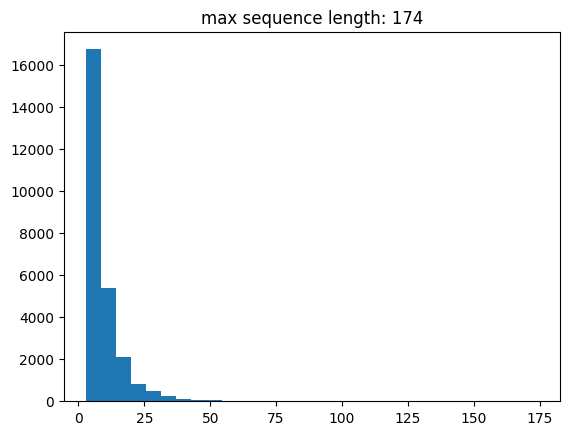

In [241]:
import matplotlib.pyplot as plt

# Check the sequence length distribution after encoding into the BERT-formatted tokenized sequence
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in train_conda_sents]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

Encoding the dataset with Tokenizer

In [250]:
import numpy as np

def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        if len(encoded)>max_length:
            token_ids[i, :] = encoded[:max_length]
        else:
            token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_masks}

# Encode the training set
# Here we use 50 as our max sequence length for simplicity
encoded_train = encode_dataset(tokenizer, train_conda_sents, 50)

# The converted result is a padded numpy array of integers that has shape (data_size, max_length), i.e., (26087, 175) in this case.
# As you can see all the 0s in the end means padding
encoded_train["input_ids"]

array([[  101,   192,  4064, ...,     0,     0,     0],
       [  101,   160, 22169, ...,     0,     0,     0],
       [  101,   192,  3186, ...,     0,     0,     0],
       ...,
       [  101,   138,  3048, ...,     0,     0,     0],
       [  101,  1285,  1358, ...,     0,     0,     0],
       [  101,   144,  1403, ...,     0,     0,     0]], dtype=int32)

In [251]:
# Similarly, let's encode the validation and test sets
encoded_valid = encode_dataset(tokenizer, dev_conda_sents, 50)
encoded_test = encode_dataset(tokenizer, test_conda_sents, 50)

Encoding the Intent Classification Targets

In [252]:
intent_names=[d.strip() for d in open(DATA_DIR+"dataset-conda/intent_label.txt",'r').readlines()]
intent_names

['A', 'E', 'I', 'O']

In [253]:
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'A': 0, 'E': 1, 'I': 2, 'O': 3}

In [254]:
# Get the mapped intent labels for training set
intent_train = np.array([intent_map[k] for k in train_conda_intents])
intent_train

array([3, 3, 3, ..., 3, 3, 3])

In [255]:
# Similarly, get the mapped intent labels for validation and test set
intent_dev = np.array([intent_map[k] for k in dev_conda_intents])
intent_test = np.array([intent_map[k] for k in test_conda_intents])

Encoding the Slot Filling Targets

In [256]:
slot_all=[d.strip() for d in open(DATA_DIR+"dataset-conda/slot_label.txt",'r').readlines()]
slot_all

['C', 'D', 'O', 'P', 'S', 'SEPA', 'T']

In [257]:
slot_names = ["[PAD]"]
slot_names += slot_all
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
# We add the special slot label [PAD] with the corresponding index of 0
slot_map

{'[PAD]': 0, 'C': 1, 'D': 2, 'O': 3, 'P': 4, 'S': 5, 'SEPA': 6, 'T': 7}

In [258]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,
                        max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.extend([slot_map[word_label]] * len(tokens))
        if len(encoded_labels)>max_length-1:
            encoded[i, 1:] = encoded_labels[:max_length-1]
        else:
            encoded[i, 1:len(encoded_labels)+1] = encoded_labels
    return encoded


slot_train = encode_token_labels(
    train_conda_sents, train_conda_slots, tokenizer, slot_map, 50)
slot_valid = encode_token_labels(
    dev_conda_sents, dev_conda_slots, tokenizer, slot_map, 50)
slot_test = encode_token_labels(
    test_conda_sents, test_conda_slots, tokenizer, slot_map, 50)

Now, we've had every single piece of data prepared with CONDA (encoded input sequences and both intent and slot labels)! Let's move to our JointBert! 😉

In [273]:
import tensorflow as tf
import warnings
warnings. filterwarnings('ignore')
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


class JointBert(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, training=False):
        outputs = self.bert(inputs, training=training)

        sequence_output = outputs[0]
        pooled_output = outputs[1]

        # Recap: The first output of the main BERT layer has shape:
        # (batch_size, max_length, output_dim)
        # This will be used for slot filling
        sequence_output = self.dropout(sequence_output, training=training)
        slot_logits = self.slot_classifier(sequence_output)

        # Recap: The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        # This will be used for intent classification
        pooled_output = self.dropout(pooled_output, training=training)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits

# Initialize the JointBert model
joint_model = JointBert(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [274]:
# Configure the training settings
opt = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [275]:
# Train JointBert model by fine-tuning the pretrained Bert model 
history = joint_model.fit(encoded_train, (slot_train, intent_train),validation_data=(encoded_valid, (slot_valid, intent_dev)),epochs=2, batch_size=32)

# To save the running time, here we will directly load the weights of the model that we've already trained over 2 epochs for demonstration. Uncomment to load the saved model.
# If you want to train it yourself, you can use the above code for training using .fit() above - make sure you are using the GPU runtime for faster training
#joint_model.load_weights(DATA_DIR+'jointbert-conda2/jointbert-conda2')

Epoch 1/2
816/816 [==============================] - 334s 383ms/step - loss: 0.4473 - output_1_loss: 0.0755 - output_2_loss: 0.3718 - output_1_accuracy: 0.9785 - output_2_accuracy: 0.8919 - val_loss: 0.3110 - val_output_1_loss: 0.0307 - val_output_2_loss: 0.2803 - val_output_1_accuracy: 0.9907 - val_output_2_accuracy: 0.9187
Epoch 2/2
816/816 [==============================] - 316s 387ms/step - loss: 0.2791 - output_1_loss: 0.0293 - output_2_loss: 0.2498 - output_1_accuracy: 0.9911 - output_2_accuracy: 0.9249 - val_loss: 0.3079 - val_output_1_loss: 0.0207 - val_output_2_loss: 0.2872 - val_output_1_accuracy: 0.9938 - val_output_2_accuracy: 0.9149


In [115]:
# We will directly use the seqeval package for sequence labeling evaluation, which supports the BIO format (For more details, please see: https://pypi.org/project/seqeval/)
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [264]:
# Evaluation functions modified based on joint NLU implemented by monologg from https://github.com/monologg/JointBERT/blob/master/utils.py

# Since here the slot is token-based (NOT in BIO format), we will use the normal f1 score based on the paper
from sklearn.metrics import f1_score as conda_slot_f1

def compute_metrics(intent_preds, intent_labels, slot_preds, slot_labels):
    assert len(intent_preds) == len(intent_labels) == len(slot_preds) == len(slot_labels)
    results = {}
    intent_result = get_intent_acc(intent_preds, intent_labels)
    slot_result = get_slot_metrics(slot_preds, slot_labels)
    sementic_result = get_sentence_frame_acc(intent_preds, intent_labels, slot_preds, slot_labels)

    results.update(intent_result)
    results.update(slot_result)
    results.update(sementic_result)

    return results

def get_intent_acc(preds, labels):
    # Calculate intent accuracy 
    acc = (preds == labels).mean()
    return {
        "intent_acc": acc
    }

def get_slot_metrics(preds, labels):
    # Calculate F1 for slot labeling
    preds_all = []
    labels_all = []
    for i,j in zip(preds,labels):
      preds_all.extend(i)
      labels_all.extend(j)

    assert len(preds) == len(labels)
    return {
        "slot_f1": conda_slot_f1(labels_all, preds_all, average='micro')
    }

def get_sentence_frame_acc(intent_preds, intent_labels, slot_preds, slot_labels):
    # Calculate the semantic frame accuracy
    """For the cases that intent and all the slots are correct (in one sentence)"""
    # Get the intent comparison result
    intent_result = (intent_preds == intent_labels)

    # Get the slot comparision result
    slot_result = []
    for preds, labels in zip(slot_preds, slot_labels):
        assert len(preds) == len(labels)
        one_sent_result = True
        for p, l in zip(preds, labels):
            if p != l:
                one_sent_result = False
                break
        slot_result.append(one_sent_result)
    slot_result = np.array(slot_result)

    sementic_acc = np.multiply(intent_result, slot_result).mean()
    return {
        "sementic_frame_acc": sementic_acc
    }

In [270]:

# Get the prediction logits for test set
s_logits, i_logits = joint_model.predict(encoded_test)


# Get the predicted slot index and ground truth slot index - both paddings and label O are ignored (according to the original paper of CONDA)
slot_predict_list=[[] for _ in range(slot_test.shape[0])]
slot_label_list=[[] for _ in range(slot_test.shape[0])]
for i in range(slot_test.shape[0]):
  for j in range(slot_test.shape[1]):
    if slot_test[i][j] not in [slot_map['[PAD]'],slot_map['O']]:
      slot_label_list[i].append(slot_test[i][j])
      slot_predict_list[i].append(np.argmax(s_logits[i][j]))
    

# Get the predicted intent ids - we can directly compare the predicted id with the ground truth id for calculating the accuracy
intent_predict_list = np.argmax(i_logits, axis=1)

272/272 [==============================] - 31s 103ms/step


In [271]:
evaluation_results = compute_metrics(intent_predict_list, intent_test, slot_predict_list, slot_label_list)
evaluation_results

{'intent_acc': 0.9119944852941176,
 'slot_f1': 0.9382778285390215,
 'sementic_frame_acc': 0.8193933823529411}